In [3]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
 
print("TensorFLow Version : ",tf.__version__)
print("Is Using GPU ?", tf.test.is_gpu_available())

TensorFLow Version :  2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is Using GPU ? False


In [4]:
def get_three_classes(x,y):#the total number of training examples is around 60,000 and test examples are around 10,000 so we are using the subset so that training becomes faster 
    # we are indulging only in the first 3 classes
    indices_0,_ = np.where(y==0.)
    indices_1,_ = np.where(y==1.)
    indices_2,_ = np.where(y==2.)
    
    indices = np.concatenate([indices_0,indices_1,indices_2],axis =0)# concatenating along the first axis , in a particular  sequence (hence we need to shuffle them later)
    #selecting the examples  corresponding to the given indices 
    x =  x[indices]
    y =  y[indices]
    
    count = x.shape[0] #This gives the total numbers of the examples selected
   
    #shuffling the indices, 
    indices = np.random.choice(range(count), count , replace=False)#replace = False ensures that we only have unique values
    
    x =  x[indices]
    y =  y[indices]
    
    y = tf.keras.utils.to_categorical(y) #converting the labels into one hot encoded vectors
    
    return x,y
    

In [5]:
#Loading the data set
(x_train,y_train) ,(x_test,y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 64s 0us/step


In [6]:
#getting the required data and lables according to the 3 chosen classes
x_train,y_train = get_three_classes(x_train ,y_train)
x_test , y_test = get_three_classes(x_test,y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape,y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


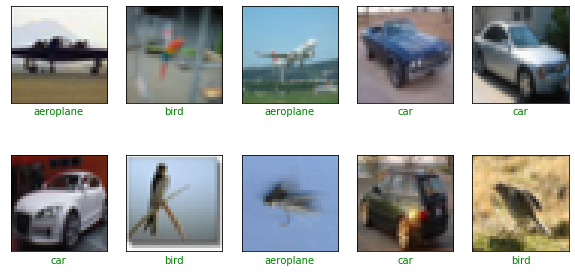

In [8]:
#Visualizing the examples 
classes_name = ['aeroplane','car','bird']

def show_random_examples(x,y,p):#p - prediction (if any)
    indices = np.random.choice(range(x.shape[0]),10,replace= False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10,5))
    
    for i in range(10):
        plt.subplot(2,5,1+i)# 2-rows , 5-columns 
        plt.imshow(x[i])
        #eliminating the ticks along x-axis and y-axis to have clear image
        plt.xticks([])
        plt.yticks([])
        col="green" if np.argmax(y[i]) == np.argmax(p[i]) else "red"
        plt.xlabel(classes_name[np.argmax(p[i])],color=col)
    plt.show()
    
show_random_examples(x_train,y_train,y_train)    
        



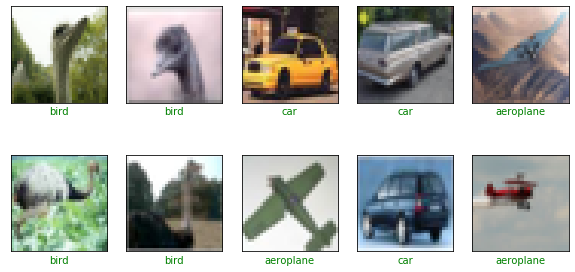

In [9]:
show_random_examples(x_test,y_test,y_test) 

In [10]:
#Creating the model :

from tensorflow.keras.layers import Conv2D , MaxPooling2D ,BatchNormalization ,Dropout ,Flatten, Input,Dense

In [13]:
def create_model():
    def add_conv_block(model , num_filters):
        model.add(Conv2D(num_filters,3, activation='relu',padding='same',))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters,3, activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.5))
        return model
        
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32,32,3)))
    
    model =  add_conv_block(model,32)
    model =  add_conv_block(model,64)
    model =  add_conv_block(model,128)
    
    model.add(Flatten())
    model.add(Dense(3,activation ='softmax'))
    
    model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']          
    )
    
    return model
    

In [15]:
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 15, 64)       

In [ ]:
#Training the model

history = model.fit(
    x_train/255. , y_train,
    validation_data =(x_test/255. , y_test),
    epochs =10,
    batch_size=128,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor ='val_accuracy', patience = 3),#if the validation accuracy does not increase for 3 iterations then we will stop the traing
        tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5',save_best_only=True,save_weights_only=False , monitor='val_accuracy'
                                          )
    ]
)

Epoch 1/10
118/118 [==============================] - 54s 456ms/step - loss: 0.8971 - accuracy: 0.6767 - val_loss: 3.0436 - val_accuracy: 0.3333
Epoch 2/10
118/118 [==============================] - 62s 528ms/step - loss: 0.5594 - accuracy: 0.7733 - val_loss: 2.3615 - val_accuracy: 0.5230
Epoch 3/10
118/118 [==============================] - 59s 500ms/step - loss: 0.4936 - accuracy: 0.8017 - val_loss: 2.1796 - val_accuracy: 0.5293
Epoch 4/10
118/118 [==============================] - 59s 500ms/step - loss: 0.4542 - accuracy: 0.8199 - val_loss: 0.8768 - val_accuracy: 0.6493
Epoch 5/10
118/118 [==============================] - 59s 498ms/step - loss: 0.4203 - accuracy: 0.8363 - val_loss: 0.9579 - val_accuracy: 0.6790
Epoch 6/10
115/118 [============================>.] - ETA: 28s - loss: 0.3818 - accuracy: 0.8510